In [1]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import *
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble
from sklearn.utils import parallel_backend
from joblibspark import register_spark
from sklearn.metrics import mean_absolute_error

In [2]:
spark = SparkSession.builder.appName("Vu dep trai").config("spark.executor.memory","9g").getOrCreate()
# conf = pyspark.SparkConf().setMaster("spark://node-master:7077")\
#         .setAppName("Vu dep trai")\
#         .set("spark.executor.memory","15g")
# # sc = SparkContext.getOrCreate(conf=conf)
# # spark.stop()
# sc = SparkContext(conf = conf)
# spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/03 10:14:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df_stores_raw = spark.read.csv("data/ba-walmart/stores.csv", header=True, inferSchema=True)
df_feature_raw = spark.read.csv("data/ba-walmart/features.csv", header=True, inferSchema=True)
df_train_raw = spark.read.csv("data/ba-walmart/train.csv", header=True, inferSchema=True)
df_test_raw = spark.read.csv("data/ba-walmart/test.csv", header=True, inferSchema=True)

In [4]:
df_feature = df_feature_raw.drop("MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5")
df = df_train_raw.join(df_feature, how="left", on=["Store", "Date", "IsHoliday"], ).join(df_stores_raw, how="left", on=["Store"])
df_test = df_test_raw.join(df_feature, how="left", on=["Store", "Date", "IsHoliday"]).join(df_stores_raw, how="left", on=["Store"])
df = df.withColumn("CPI", df["CPI"].cast(FloatType())).withColumn("Unemployment", df["Unemployment"].cast(FloatType()))
df_test = df_test.withColumn("CPI", df_test["CPI"].cast(FloatType())).withColumn("Unemployment", df_test["Unemployment"].cast(FloatType()))


In [5]:
df = df.withColumn("Year", year("Date")).withColumn("Month", month("Date")).withColumn("Week", weekofyear("Date"))
df_test = df_test.withColumn("Year", year("Date")).withColumn("Month", month("Date")).withColumn("Week", weekofyear("Date"))
df = df.withColumn("IsHoliday", df["IsHoliday"].cast(IntegerType()))
df_test = df_test.withColumn("IsHoliday", df_test["IsHoliday"].cast(IntegerType()))

In [6]:
df_clean = df.filter(df["Weekly_Sales"] > 0)
df_clean = df_clean.filter(df_clean["Weekly_Sales"] < 450000)

In [7]:
types = df_clean.select("Type").distinct().collect()
types.sort()
mapping = {t.Type: str(i) for i, t in enumerate(types)}
df_clean = df_clean.replace(mapping, subset=["Type"])
df_test = df_test.replace(mapping, subset=["Type"])
df_clean = df_clean.withColumn("Type", df_clean["Type"].cast(IntegerType()))
df_test = df_test.withColumn("Type", df_test["Type"].cast(IntegerType()))

In [8]:
## From EDA select important columns
input_col = ['Store', 'IsHoliday', 'Type', 'Size', 'Week','Dept','Year']
target = 'Weekly_Sales'

In [9]:
# split 80% first data for training
df_train, df_valid = df_clean.randomSplit([0.8, 0.2], seed=1234)

In [10]:
df_train_pd = df_train.toPandas()
df_valid_pd = df_valid.toPandas()

/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [11]:
print(df_train_pd.shape)
print(df_valid_pd.shape)

(336680, 14)
(83527, 14)


In [12]:
register_spark()

rnd = sklearn.ensemble.RandomForestRegressor()

# grid_param = {
#     'max_depth': [25, 30, 35],
#     'max_features': [1.0, 0.9, 0.8],
#     'max_samples': [0.5, 0.75, 1.0]
# }

# simulate grid search
grid_param = {
    'max_depth': [30],
    'max_features': [1.0],
    'max_samples': [0.8, 0.9]
}


with parallel_backend('spark'):
    grid_search = GridSearchCV(estimator=rnd,
                               param_grid=grid_param,
                               cv=3,
                               n_jobs=9,
                               verbose=2)
    grid_search.fit(df_train_pd[input_col], df_train_pd[target])


23/02/03 10:15:01 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[CV] END ....max_depth=30, max_features=1.0, max_samples=0.8; total time=  37.7s
[CV] END ....max_depth=30, max_features=1.0, max_samples=0.8; total time=  38.0s
[CV] END ....max_depth=30, max_features=1.0, max_samples=0.8; total time=  39.4s
[CV] END ....max_depth=30, max_features=1.0, max_samples=0.9; total time=  40.4s
[CV] END ....max_depth=30, max_features=1.0, max_samples=0.9; total time=  40.3s
[CV] END ....max_depth=30, max_features=1.0, max_samples=0.9; total time=  41.8s


In [13]:
grid_search.best_params_

{'max_depth': 30, 'max_features': 1.0, 'max_samples': 0.8}

In [14]:
y_pred = grid_search.predict(df_train_pd[input_col])
mean_absolute_error(df_train_pd[target], y_pred)

604.6576073012831

In [15]:
y_pred = grid_search.predict(df_valid_pd[input_col])
mean_absolute_error(df_valid_pd[target], y_pred)

1332.4250423451977

<AxesSubplot: xlabel='importance'>

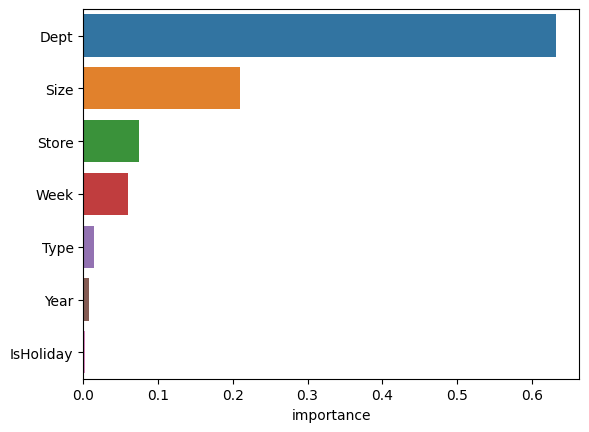

In [16]:
importance = grid_search.best_estimator_.feature_importances_
importance = pd.DataFrame(importance, index=input_col, columns=["importance"])
importance = importance.sort_values(by="importance", ascending=False)
sns.barplot(y=importance.index, x=importance["importance"], orient = 'h')